<a href="https://colab.research.google.com/github/Pankaj1357/HC18-Grand-Challenge/blob/master/HC18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Compared with MVP:
#     Increased Learning rate to 0.0154
#     Cosine Scheduler for learning rate

In [2]:
import cv2
import os
import matplotlib.pyplot as plt
import pandas as pd
import time

# **Mask Generation**
Done only once and replaced that  annotation with masks permanently
Did not changed the annotation file name though

## **Warning!!!**
Do not run below cells as task is already completed

In [3]:
train_pixel_file = pd.read_csv('training_set_pixel_size_and_HC.csv')
train_pixel_file.head()
# This Dataframe will be used to extract image names hence by doing image_name + '_Annotation' we will get annotation names

,filename,pixel size(mm),head circumference (mm)
0,000_HC.png,0.069136,44.30
1,001_HC.png,0.089659,56.81
2,002_HC.png,0.062033,68.75
3,003_HC.png,0.091291,69.00
4,004_HC.png,0.061240,59.81


In [4]:
# This function takes annotation and spits out corresponding mask
def masking(image):
    imgray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(imgray, 127, 255, 0)
    contours,useless = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    ellipse = cv2.fitEllipse(contours[0])
    return cv2.ellipse(image, ellipse, (255,255,255), -1)

training_set/000_HC_Annotation.png
training_set/001_HC_Annotation.png
training_set/002_HC_Annotation.png
training_set/003_HC_Annotation.png
training_set/004_HC_Annotation.png
training_set/005_HC_Annotation.png
training_set/006_HC_Annotation.png


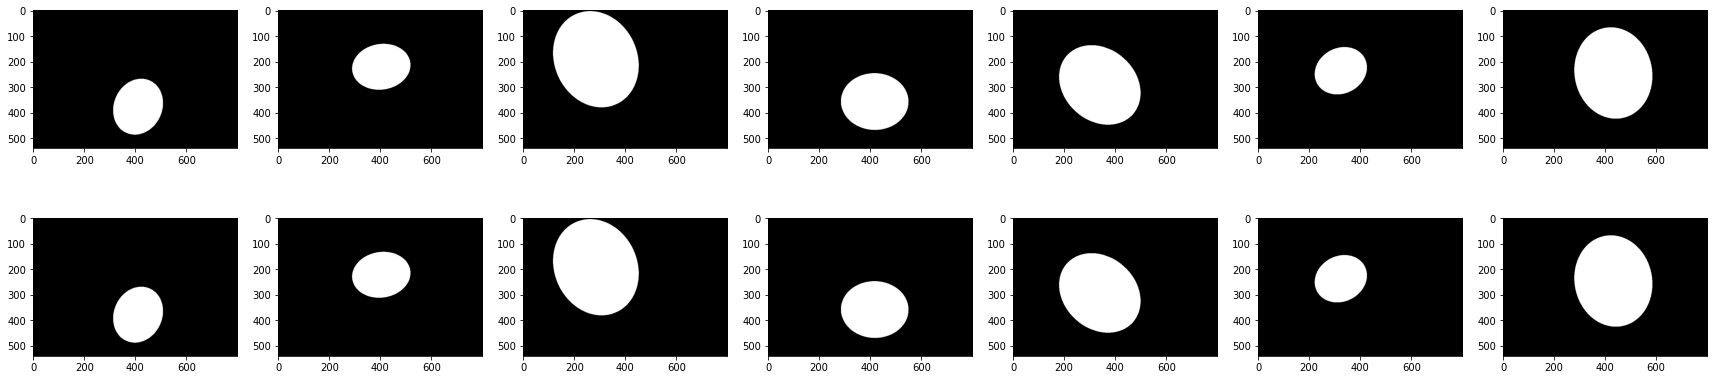

In [5]:
# to check if our masking function is working correctly
fig = plt.figure(figsize = (30,7))
for index in range(7):
  file_path = os.path.join('training_set', train_pixel_file.iloc[index, 0].replace('.png','_Annotation.png'))
  print(file_path)
  ax = fig.add_subplot(2, 7, index+1)             ## annoted plot
  plt.imshow(cv2.imread(file_path))
    
  ax = fig.add_subplot(2, 7, index+8)
  plt.imshow(masking(cv2.imread(file_path)))        ## mask plot

In [6]:
# Here we loop through training set and  take annotations one by one and replace them with corresponding masks
fig = plt.figure(figsize = (30,7))
for index in range(len(train_pixel_file)):
    file_path = os.path.join('training_set', train_pixel_file.iloc[index, 0].replace('.png','_Annotation.png'))
    image = cv2.imread(file_path)
    mask = masking(image)
    cv2.imwrite(file_path, mask)

<Figure size 2160x504 with 0 Axes>

## **Warning!!!**
**Done with mask generation. Don't run above cells ever again**

### **Do all the imports in below cell**

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from skimage import io, color
from PIL import Image
import cv2

import os
import random

import torch
from torch.utils.data  import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as TF
import torch.nn as nn
import torch.nn.functional as F
import torchvision

In [8]:
validation_set_size = 0.20            # fraction of dataset used for validation which will be splited randomly

In [9]:
# our dataset class
class HC18(Dataset):
  #""" train and validation dataset class"""
    def __init__(self, root_dir, train = True, transformX = None, transformY = None):
        self.pixel_file = pd.read_csv(os.path.join(root_dir, 'training_set_pixel_size_and_HC.csv'))
        self.root_dir = root_dir
        self.transformX = transformX
        self.transformY = transformY
        self.train = train
        
        # lets split the dataset in train and validation
        self.train_data, self.validation_data = train_test_split(self.pixel_file, test_size = validation_set_size, random_state = 5)
        
    def __len__(self):
        
        if self.train:
          length = len(self.train_data)
        else:
          length = len(self.validation_data)
        return length
    
    def __getitem__(self, index):
      
        if self.train:
          imx_name = os.path.join(self.root_dir, 'training_set', self.train_data.iloc[index, 0])
          imy_name = os.path.join(self.root_dir, 'training_set',self.train_data.iloc[index, 0].replace('.png','_Annotation.png'))

        else:
          imx_name = os.path.join(self.root_dir, 'training_set', self.validation_data.iloc[index, 0])
          imy_name = os.path.join(self.root_dir, 'training_set',self.validation_data.iloc[index, 0].replace('.png','_Annotation.png'))
        
        
        imx = Image.open(imx_name)
        imy = Image.open(imy_name).convert('L')
        
        ## tried some data augmentation techniques
        if self.train:
          # Random horizontal flipping
          if random.random() > 0.5:
              imx = TF.hflip(imx)
              imy = TF.hflip(imy)

          # Random vertical flipping
          if random.random() > 0.5:
              imx = TF.vflip(imx)
              imy = TF.vflip(imy)


          # Random rotation
          if random.random() > 0.8:
            angle = random.choice([-30, -90, -60, -45 -15, 0, 15, 30, 45, 60, 90])
            imx = TF.rotate(imx, angle)
            imy = TF.rotate(imy, angle)
        
        
        
        
        
        
        if self.transformX :
            imx = self.transformX(imx)
            imy = self.transformY(imy)
        
        sample = {'image': imx, 'annotation': imy}
        return sample

In [ ]:
# our datasets
tx_X = transforms.Compose([ transforms.Resize((572, 572)),
                              transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,))
                              ])
tx_Y = transforms.Compose([ transforms.Resize((572, 572)),
                              transforms.ToTensor(),  ################ no need to normalize the maskk
                             # transforms.Normalize((0.5,), (0.5,))
                              ])
train_data = HC18('', train = True, transformX = tx_X, transformY = tx_Y)
validation_data = HC18('', train = False, transformX = tx_X, transformY = tx_Y )

In [11]:
# our dataloaders
train_loader = DataLoader(dataset = train_data, batch_size = 2, shuffle = True, num_workers = 2 )
validation_loader = DataLoader(dataset = validation_data, batch_size = 2, shuffle = True, num_workers = 2)

In [12]:
# this function will return numpy array from the transformed tensors which were
# obtained from our train_loader. Just to plot them and see if they are intact :) ha ha
def im_converterX(tensor):
    image = tensor.cpu().clone().detach().numpy() # make copy of tensor and converting it to numpy as we will need original later
    image = image.transpose(1,2,0) # swapping axes making (1, 28, 28) image to a (28, 28, 1)
 # print(image.shape)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5)) # unnormalizing the image # this also outputs (28, 28, 3) which seems important for plt.imshow
    image = image.clip(0, 1) # to make sure final values are in range 0 to 1 as .ToTensor outputed
    return image

In [13]:
# this function will return numpy array from the transformed tensors which were
# obtained from our train_loader. Just to plot them and see if they are intact :) ha ha
def im_converterY(tensor):
    image = tensor.cpu().clone().detach().numpy() # make copy of tensor and converting it to numpy as we will need original later
    image = image.transpose(1,2,0) # swapping axes making (1, 28, 28) image to a (28, 28, 1)
 # print(image.shape)
    image = image * np.array((1, 1, 1)) # unnormalizing the image  not needed# this also outputs (28, 28, 3) which seems important for plt.imshow
    image = image.clip(0, 1) # to make sure final values are in range 0 to 1 as .ToTensor outputed
    return image

0 torch.Size([2, 1, 572, 572]) torch.Size([2, 1, 572, 572])


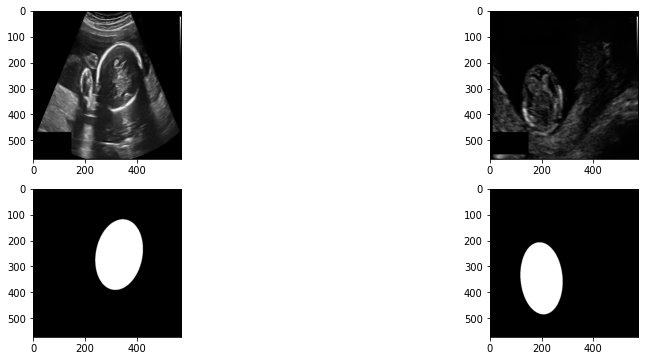

In [14]:
## Here we loop through our train_loader and see the images
## Looks good
fig = plt.figure(figsize = (15,6))
for ith_batch, sample_batched in enumerate(train_loader):
    print(ith_batch, sample_batched['image'].size(), sample_batched['annotation'].size())
    
    for index in range(2):
        ax = fig.add_subplot(2, 2 , index + 1)  # subplot index starts from 1
        plt.imshow(im_converterX(sample_batched['image'][index]))
        ax = fig.add_subplot(2, 2, index + 3)
        plt.imshow(im_converterY(sample_batched['annotation'][index]))
    break

In [15]:
class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''

    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            #nn.Dropout2d(0.7),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            #nn.Dropout2d(0.77),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        if bilinear: #upsampling will not be learnable
            self.up = nn.Upsample(
                scale_factor=2, mode='bilinear', align_corners=True)
        else:  # it will be learnable here
            self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, 2, stride=2)
        
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2))

        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x
    
    
class attention_gate(nn.Module):
    def __init__(self, in_ch_g,in_ch_x,out_ch):
        super(attention_gate, self).__init__()
        self.conv = nn.Conv2d(in_ch_g,in_ch_x, 1)
        self.conv_att = nn.Conv2d(in_ch_x,in_ch_x,1)
#         self.resampler = nn.Conv2d()

#     x orignal, g new
    def forward(self,g,x):
        orig_x = x        
#         upconv then downsample x
#         print(f'g = {g.shape}')
#         print(f'x = {x.shape}')
        g = self.conv(g)
        
        g = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)(g)
        diffY = x.size()[2] - g.size()[2]
        diffX = x.size()[3] - g.size()[3]

        g = F.pad(g, (diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2))
    
        a = g + x
        a = nn.ReLU()(a)
        a = nn.Sigmoid()(a)
        a = a * orig_x
        a = self.conv_att(a)
#         a = torch.reshape(a,shape)
        return a

In [16]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 16)
        self.down1 = down(16, 32)
        self.down2 = down(32, 64)
        self.down3 = down(64, 64)
#         self.down4 = down(512, 512)
        self.up1 = up(128, 32, bilinear = False) # upsampling weights are made learnable
        self.up2 = up(64, 16, bilinear = False)
        self.up3 = up(32, 8, bilinear = False)
#         self.up4 = up(32, 8, bilinear = False)
       
        self.dropout = torch.nn.Dropout2d(0.382)
        self.ag3 = attention_gate(64,64,64)
        self.ag2 = attention_gate(32,32,32)
        self.ag1 = attention_gate(16,16,16)
        self.bot_conv1 = nn.Conv2d(64,8,3)
        self.bot_conv2 = nn.Conv2d(32,8,3)
        self.bot_conv3 = nn.Conv2d(16,8,3)
        self.bot_conv4 = nn.Conv2d(8,8,3)
        self.upsample1 = nn.Upsample(scale_factor=8, mode='bilinear', align_corners=True)
        self.upsample2 = nn.Upsample(scale_factor=4, mode='bilinear', align_corners=True)
        self.upsample3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.outc = outconv(32, n_classes)
        
    def forward(self, x):
        x = x.float()
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x2 = self.dropout(x2)
        x3 = self.down2(x2)
        x3 = self.dropout(x3)
        x4 = self.down3(x3)
        x4 = self.dropout(x4)
        ag3 = self.ag3(x4,x3)
        y1 = self.up1(x4, ag3)
        y1 = self.dropout(y1)
        ag2 = self.ag2(y1,x2)
        y2 = self.up2(y1,ag2)
        y2 = self.dropout(y2)
        ag1 = self.ag1(y2,x1)
        y3 = self.up3(y2,ag1)
        y3 = self.dropout(y3)
        #x = self.dropout(x) #
#         y3 = self.outc(y3)
#         y3 = torch.sigmoid(y3)
#         print(x4.shape) 
        
        # Bottom
        
        x4 =  self.bot_conv1(x4)
        x4 =  F.pad(x4,(1,1,1,1))
        y1 =  self.bot_conv2(y1)
        y1 = F.pad(y1,(1,1,1,1))
        y2 =  self.bot_conv3(y2)
        y2 = F.pad(y2,(1,1,1,1))
        y3 =  self.bot_conv4(y3)
        y3 = F.pad(y3,(1,1,1,1))
       
        x4 = self.upsample1(x4)
        x4 = F.pad(x4,(2,2,2,2))
        y1 = self.upsample2(y1)
        y2 = self.upsample3(y2)
        
        final = torch.cat([x4,y1,y2,y3], dim=1)
        final = self.outc(final)
        return torch.sigmoid(final)
      
      
      
      
      
      
model = UNet(1, 1)
model.to('cuda')
print("Model Loaded to GPU")

Model Loaded to GPU


In [17]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0154)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0)

In [18]:
# calculates similarity index between predicted and actual segmentation
def dice_index(y_pred, y_actual):
    smooth = 0.000001
    size_of_batch = y_pred.size(0)
    
    p1 = y_pred.view(size_of_batch, -1)
    p2 = y_actual.view(size_of_batch, -1)
    
    intersection = (p1 * p2).sum()
    
    dice =  ((2.0 * intersection )+ smooth) / (p1.sum() + p2.sum() + smooth)
    #dice.requires_grad = True
    
    return dice

In [19]:
# calculate dice loss which will be later used in loss function calculation
def dice_loss(y_predict, y_train): ## to add in bce looss
  
  dice_loss = 1 -(dice_index(y_predict, y_train))
  
  return dice_loss
  

In [ ]:
epochs = 150


train_running_loss_history = []
validation_running_loss_history =[]
start_time_training = time.time()
for e in range(epochs):
  start_time_epoch = time.time()
  train_running_loss = 0.0
  validation_running_loss = 0.0
  
  model.train()
  
  for ith_batch, sample_batched in enumerate(train_loader):
    X_train = sample_batched['image'].to('cuda')
    y_train = sample_batched['annotation'].to('cuda')
    
    #X_train.requires_grad = True
    #y_train.requires_grad = True

    #print(ith_batch) #, X_train.size(), y_train.size())

    optimizer.zero_grad()
    y_pred = model(X_train)
   # out = (y_pred + 0.5).int().float()
    
    loss = 0.30 * dice_loss(y_pred, y_train) +  0.70 * criterion(y_pred, y_train)
    #loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()
    
#     if ith_batch % 50 == 0:
#       print('Epoch: ', e + 1, 'Batch: ', ith_batch, 'Current Loss: ', loss.item())
      
    train_running_loss += loss.item()
    
    
    
    
  else:
    with torch.no_grad():
      
      model.eval()
      
      for ith_batch, sample_batched in enumerate(validation_loader):
          X_val = sample_batched['image'].to('cuda')
          y_val = sample_batched['annotation'].to('cuda')
          
          
          
          y_out = model(X_val)
          out_val = (y_out + 0.5).int().float()
          
          val_loss = 0.3 * dice_loss(out_val, y_val)  + 0.7 * criterion(y_out, y_val)
          
          #val_loss = criterion(y_out, y_val)
          
          validation_running_loss += val_loss.item()
      print("================================================================================")
      print("Epoch {} completed".format(e + 1))
      
      train_epoch_loss = train_running_loss / len(train_loader)
      validation_epoch_loss = validation_running_loss / len(validation_loader)
      
      print("Average train loss is {}: ".format(train_epoch_loss))
      print("Average validation loss is {}".format(validation_epoch_loss))
      train_running_loss_history.append(train_epoch_loss)
      validation_running_loss_history.append(validation_epoch_loss)
                                             
      # Timer and graph
      print("total running time is %s minutes" % ((time.time() - start_time_training)/60))                                       
      print("================================================================================")                                       
      if e % 5 == 0:
          plt.plot(train_running_loss_history, label = 'Train Loss')
          plt.plot(validation_running_loss_history, label = 'Validation Loss')
          plt.legend()
      #print(y_pred.shape)

    #y_pred = y_pred.to('cpu')
    #X_train = X_train.to('cpu')

    #del y_train
    #torch.cuda.empty_cache()
    #if ith_batch ==100:
    #break
  #for index in range(2):
  #         ax = gig.add_subplot(2, 2 , index + 1)  # subplot index starts from 1
   #         plt.imshow(im_converter(X_train[index]))
    #        ax = gig.add_subplot(2, 2, index + 3)
     #       plt.imshow(im_converter(y_pred[index]))
  


Epoch 1 completed
Average train loss is 0.5266485670208931: 
Average validation loss is 0.4445231756567955
total running time is 1.6721140225728353 minutes
Epoch 2 completed
Average train loss is 0.4657658413052559: 
Average validation loss is 0.4504532840847969
total running time is 3.3467273314793906 minutes
Epoch 3 completed
Average train loss is 0.4343516568094492: 
Average validation loss is 0.4089999571442604
total running time is 5.0173753579457605 minutes
Epoch 4 completed
Average train loss is 0.42342614360153674: 
Average validation loss is 0.6735110688209534
total running time is 6.6949489196141565 minutes
Epoch 5 completed
Average train loss is 0.410968594327569: 
Average validation loss is 0.35620100498199464
total running time is 8.367754785219828 minutes
Epoch 6 completed
Average train loss is 0.39937076091766355: 
Average validation loss is 1.0038741835951805
total running time is 10.039209806919098 minutes
Epoch 7 completed
Average train loss is 0.3914738494157791: 
Av

Epoch 27 completed
Average train loss is 0.3469130953401327: 
Average validation loss is 0.7849332174658775
total running time is 45.19957462946574 minutes
Epoch 28 completed
Average train loss is 0.34335983365774153: 
Average validation loss is 0.3217798683047295
total running time is 46.872275511423744 minutes
Epoch 29 completed
Average train loss is 0.3460892777889967: 
Average validation loss is 0.4714124409854412
total running time is 49.079524807135265 minutes
Epoch 30 completed
Average train loss is 0.34016809463500974: 
Average validation loss is 0.3218830668926239
total running time is 51.60256368716558 minutes
Epoch 31 completed
Average train loss is 0.33998081140220165: 
Average validation loss is 0.35291289880871773
total running time is 54.12728367249171 minutes
Epoch 32 completed
Average train loss is 0.3361116006597877: 
Average validation loss is 0.31416899904608725
total running time is 56.65047622919083 minutes
Epoch 33 completed
Average train loss is 0.33912746585905

In [ ]:
torch.save(model,"Models/MFP_Cos_more_dropout_150.pt")    

In [ ]:
plt.plot(train_running_loss_history, label = 'Train Loss')
plt.plot(validation_running_loss_history, label = 'Validation Loss')
plt.legend()

In [ ]:
model.eval()
X_train.size()

In [ ]:
out = (y_pred + 0.5).int().float()

In [ ]:
print(dice_index(y_train, out))
print(dice_loss(y_train, out))

In [ ]:
# pig = plt.figure(figsize = (15, 6))

# a = pig.add_subplot(2, 3, 1)
# plt.imshow(im_converterX(X_train[0]))

# a = pig.add_subplot(2, 3, 2)
# plt.imshow(im_converterY(y_train[0]))

# a = pig.add_subplot(2, 3, 3)
# plt.imshow(im_converterY(out[0]))


# a = pig.add_subplot(2, 3, 4)
# plt.imshow(im_converterX(X_train[1]))

# a = pig.add_subplot(2, 3, 5)
# plt.imshow(im_converterY(y_train[1]))

# a = pig.add_subplot(2, 3, 6)
# plt.imshow(im_converterY(out[1]))

In [ ]:
gg = dice_index(out, y_train)
print(gg)
print(dice_loss(out, y_train))

In [ ]:
class HC18_test(Dataset):
    def __init__(self, root_dir, transformX = None):
        self.pixel_file = pd.read_csv(os.path.join(root_dir, 'test_set_pixel_size.csv'))
        self.root_dir = root_dir
        self.transformX = transformX
        
    def __len__(self):
        return len(self.pixel_file)
    
    def __getitem__(self, index):
        imx_name = os.path.join(self.root_dir, 'test_set', self.pixel_file.iloc[index, 0])
        
        imx = Image.open(imx_name)
        
        f_name = self.pixel_file.iloc[index, 0]
        
        if self.transformX :
            imx = self.transformX(imx)
        
        sample = {'image': imx, 'f_name': f_name}
        return sample

In [ ]:
test_data = HC18_test('', transformX = tx_X)

In [ ]:
test_data

In [ ]:
test_loader = DataLoader(dataset = test_data, batch_size = 2, shuffle = True)

In [ ]:
test_loader

In [ ]:
## Here we loop through our train_loader and see the images
## Looks good
fig = plt.figure(figsize = (15,6))
#model.to('cpu')
for ith_batch, sample_batched in enumerate(test_loader):
  
    X_test = sample_batched['image'].to('cuda')
    print(ith_batch, X_test.size())
    
    y_test = (model(X_test) + 0.5).int().float()
    
    
    
    for index in range(2):
        ax = fig.add_subplot(2, 2 , index + 1)  # subplot index starts from 1
        plt.imshow(im_converterX(X_test[index]))
        
        ax  = fig.add_subplot(2, 2, index + 3)
        plt.imshow(im_converterY(y_test[index]))
    break

In [ ]:
def avg_dice_index(dataloader):
  
    dice = 0.0
    model.eval()
    with torch.no_grad():
    
        for ith_batch, sample_batched in enumerate(dataloader):
  
            X_train = sample_batched['image'].to('cuda')
            y_train = sample_batched['annotation'].to('cuda')
            
            y_predict = (model(X_train) + 0.5).int().float()
            
            dice += dice_index(y_predict, y_train)
            
            
            
    avg_dice = dice / len(dataloader)
    return avg_dice.item()

In [ ]:
avg_dice_index(validation_loader)    #### Dice index of validation data

In [ ]:
avg_dice_index(train_loader)        ### Dice index of training data

In [ ]:
test_loader = DataLoader(dataset = test_data, batch_size = 1, shuffle = True) # to write image files

## **Warning!!!**
### Your are about to write on drive

In [ ]:
transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((540, 800)),
        transforms.ToTensor()
        ])
    
with torch.no_grad():
      #model.eval()
      for ith_batch , sample in enumerate(test_loader):
        X_test = sample['image'].to('cuda')
        y_pred = (model(X_test) + 0.5).int().float().cpu()
#         print(335-ith_batch)
        
        file_names = sample['f_name']
        pankaj = transform(y_pred[0])
        #singh = transform(y_pred[1])
        torchvision.utils.save_image(pankaj , os.path.join('segmented', file_names[0]))
        #torchvision.utils.save_image(singh, os.path.join('/content/drive/My Drive/HC18/test_set', file_names[1].replace('.png','_Annotation.png')))
      print("Segmentation files written")
        
        

In [ ]:
def fit_ellipse(im):    
    imgray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(imgray,127,255,0)
    contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    contour_sizes = [len(contour) for contour in contours]
    ellipse = cv2.fitEllipse(contours[np.argmax(contour_sizes)])
    return ellipse

In [ ]:
file_names = sorted([file for _,_,files in os.walk('segmented/') for file in files])

In [ ]:
df_pixel_size = pd.read_csv('test_set_pixel_size.csv')
submission = {'filename': [], 'center_x_mm': [], 'center_y_mm': [], 'semi_axes_a_mm': [],
             'semi_axes_b_mm': [], 'angle_rad': [], 'Index': []}

file_names = sorted([file for _,_,files in os.walk('segmented/') for file in files])

for i, file_name in enumerate(file_names):
    im = cv2.imread('segmented/'+file_name)
   # file_name = file_name.replace('_Segmented', '')
    ellipse = fit_ellipse(im)
    im_mask = cv2.ellipse(np.zeros_like(im),ellipse,(255,255,255),-1)
    image_name = file_name.split('.')[0] + '_Annotation_fit.png'
    #cv2.imwrite('/content/drive/My Drive/HC18/test_set/'+image_name, im_mask)
    
    pixel_size = df_pixel_size.loc[df_pixel_size['filename'] == file_name, 'pixel size(mm)'].iloc[0]
    submission['filename'].extend([file_name])
    submission['Index'].extend([int(file_name.split('_')[0])])
    center_x,  center_y = ellipse[0]
    submission['center_x_mm'].extend([pixel_size*center_x])
    submission['center_y_mm'].extend([pixel_size*center_y])
    semi_axes_b, semi_axes_a = ellipse[1]
    if semi_axes_b > semi_axes_a:
        semi_axes_b = semi_axes_b + semi_axes_a
        semi_axes_a = semi_axes_b - semi_axes_a
        semi_axes_b -= semi_axes_a
    submission['semi_axes_a_mm'].extend([semi_axes_a*pixel_size/2])
    submission['semi_axes_b_mm'].extend([semi_axes_b*pixel_size/2])
    angle = ellipse[2]
    if angle < 90:
        angle += 90
    else:
        angle -= 90
    submission['angle_rad'].extend([np.deg2rad(angle)])
    
submission = pd.DataFrame(submission)
submission = submission[['filename', 'center_x_mm', 'center_y_mm', 
                         'semi_axes_a_mm', 'semi_axes_b_mm', 'angle_rad', 'Index']]    
submission = submission.sort_values(['Index'])
submission = submission.drop('Index', axis=1)
submission.to_csv("MFP_Cos_150.csv", index=False)
print('Required .csv file generated')

In [ ]:
q = pd.read_csv('MFP_Cos_150.csv')  ## to check theck the generated csv

In [ ]:
print('Length of csv file: ',len(q))

In [ ]:
submission.head()